In [3]:
import sys
from sklearn.cluster import MiniBatchKMeans, KMeans

In [4]:
sys.path.insert(0, "src")
import data_functions
import embedding_functions
import cluster_functions
import util_functions

C:\Users\fra3066mat\appdata\Local\miniconda3\envs\concept-graphs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\fra3066mat\appdata\Local\miniconda3\envs\concept-graphs\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\fra3066mat\appdata\Local\miniconda3\envs\concept-graphs\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\fra3066mat\appdata\Loca

In [5]:
import pathlib
import pickle

In [6]:
grascco_data = data_functions.DataProcessingFactory.load(
    pathlib.Path("./tmp/grascco/grascco_data.pickle")
)

In [7]:
grascco_embedding = embedding_functions.SentenceEmbeddingsFactory.load(
    pathlib.Path("./tmp/grascco/grascco_data.pickle"),
    pathlib.Path("./tmp/grascco/grascco_embedding.pickle")
)

INFO:root:Building Concept Cluster ...
INFO:root:UMAP arguments: {'a': None, 'angular_rp_forest': False, 'b': None, 'dens_frac': 0.3, 'dens_lambda': 2.0, 'dens_var_shift': 0.1, 'densmap': False, 'disconnection_distance': None, 'force_approximation_algorithm': False, 'init': 'spectral', 'learning_rate': 1.0, 'local_connectivity': 1.0, 'low_memory': True, 'metric': 'euclidean', 'metric_kwds': None, 'min_dist': 0.1, 'n_components': 2, 'n_epochs': None, 'n_jobs': -1, 'n_neighbors': 15, 'negative_sample_rate': 5, 'output_dens': False, 'output_metric': 'euclidean', 'output_metric_kwds': None, 'precomputed_knn': (None, None, None), 'random_state': None, 'repulsion_strength': 1.0, 'set_op_mix_ratio': 1.0, 'spread': 1.0, 'target_metric': 'categorical', 'target_metric_kwds': None, 'target_n_neighbors': -1, 'target_weight': 0.5, 'tqdm_kwds': None, 'transform_mode': 'embedding', 'transform_queue_size': 4.0, 'transform_seed': 42, 'unique': False, 'verbose': False}
INFO:root:-- Calculating K-Elbow .

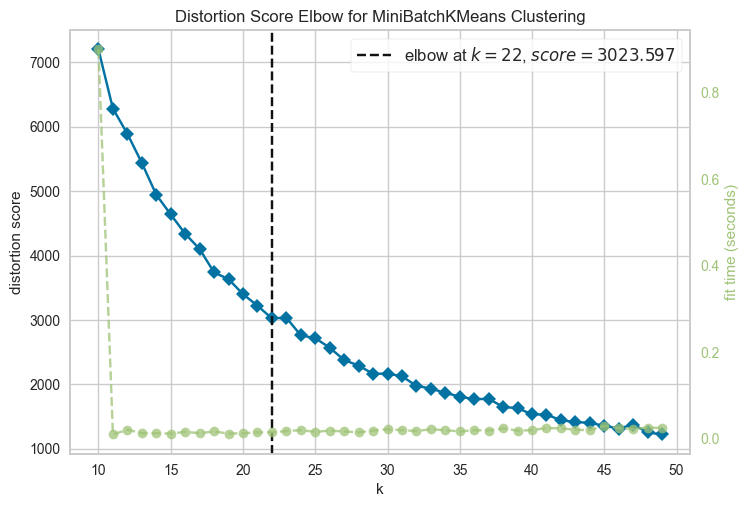

INFO:root:-- Clustering ...
INFO:root: (kmeans) with Arguments: {'n_init': 'auto'}
Number of Clusters: 22


Saved under: C:\Users\fra3066mat\PycharmProjects\concept-graphs\tmp\test_grascco_cluster_cache.pickle\grascco.pickle


In [8]:
_clustering_cache = pathlib.Path("./tmp/test_grascco_cluster_cache.pickle")
grascco_cluster = cluster_functions.PhraseClusterFactory.create(
    sentence_embeddings=grascco_embedding,
    cache_path=_clustering_cache,
    cache_name="grascco",
    cluster_algorithm="kmeans",
    # kelbow_metric="silhouette",
    kelbow_k=(10,50),
    kelbow_estimator="kmeans-mb",
)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.utils.random import sample_without_replacement
from sklearn.linear_model import LinearRegression
from umap import UMAP
from yellowbrick.cluster import kelbow_visualizer

In [10]:
umap = UMAP(n_neighbors=30, metric='cosine', min_dist=0.0)
projection_umap = umap.fit_transform(grascco_embedding.sentence_embeddings)

In [35]:
n_samples = 15
sample_fraction = 25
samples = []
for i in range(n_samples):
    samples.append(sample_without_replacement(projection_umap.shape[0], int(projection_umap.shape[0]/sample_fraction)))
mms = MinMaxScaler().fit(projection_umap)

In [36]:
int(projection_umap.shape[0]/sample_fraction)

238

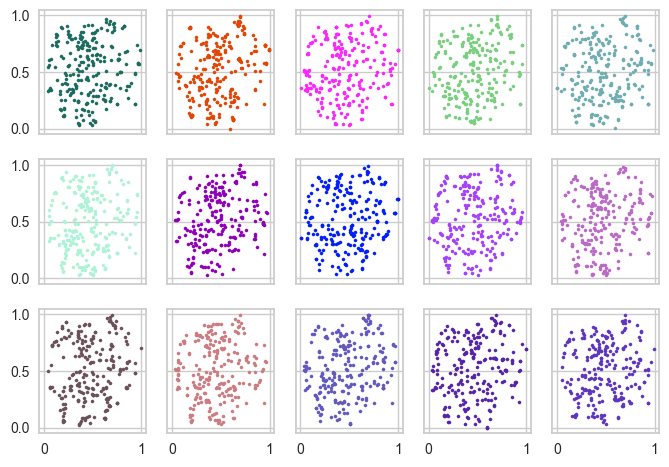

In [37]:
i = 0
_, axs = plt.subplots(3,5, sharex=True, sharey=True)
for _c in np.random.rand(n_samples,3):
    x = i%3
    y = i%5
    axs[x,y].scatter(*mms.transform(projection_umap[samples[i]]).T, s=5, color=_c)
    i += 1
plt.show()

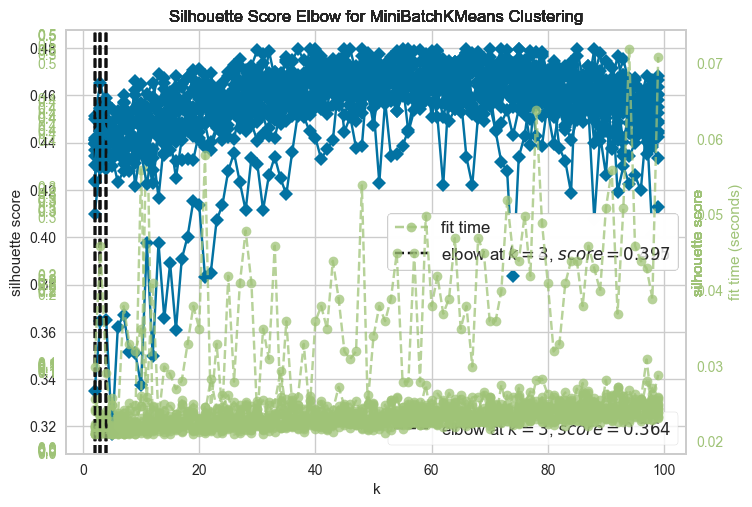

In [38]:
kelbow = []
for _sample in samples:
    _kelbow = kelbow_visualizer(
        model=MiniBatchKMeans(n_init='auto'),
        X=projection_umap[_sample],
        show=False,
        k=(2,100),
        metric='silhouette'
    )
    kelbow.append(_kelbow)


In [65]:
def fit_regression(x_reg, y_reg, degree=3):
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(np.asarray(x_reg).reshape(-1,1))

    model = LinearRegression()
    model.fit(x_poly, np.asarray(y_reg))
    
    x_lin = np.linspace(np.asarray(x_reg).min(), np.asarray(x_reg).max(), 100)
    x_out = poly.transform(x_lin.reshape(-1,1))
    y_out = model.predict(x_out)
    max_reg = np.asarray(x_reg)[np.argmax(y_out)]
    
    return x_lin, y_out, max_reg

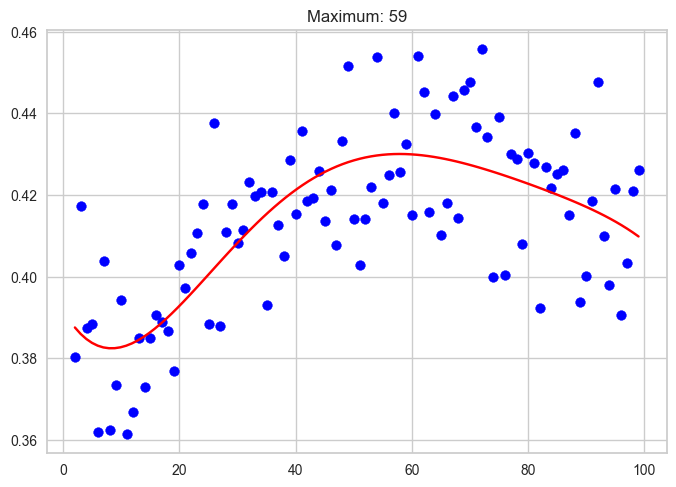

In [69]:
kelbow_val = kelbow[1]

x_vals, y_regression, max_regression = fit_regression(kelbow_val.k_values_, kelbow_val.k_scores_, 5)
plt.scatter(np.asarray(kelbow_val.k_values_).reshape(-1,1), np.asarray(kelbow_val.k_scores_), color='blue')
plt.plot(x_vals, y_regression, color='red')
plt.title(f"Maximum: {max_regression}")
plt.show()